# NYC Airbnb Data Pipeline: Market Saturation & Pricing Strategy

**Author:** Marco Flavio Delgado Martinez
**Date:** February 4, 2026
**Context:** Capstone Project 1 - Data Engineering & Governance

## Project Overview
In this project, I established a reproducible data engineering workflow to analyze the NYC Airbnb market. Leveraging a dataset of approximately 49,000 listings, I focused my analysis on two critical business questions:
1.  **Pricing Optimization:** How does listing price vary by location, and where are the high-value outliers?
2.  **Market Saturation:** Which neighborhoods are oversaturated, and does high volume correlate with lower pricing power?

## Technical Approach
* **Data Governance:** I applied strict cleaning rules to handle null values in review metrics. My priority was ensuring 100% data retention for availability analysis rather than dropping potentially valuable rows.
* **Modular Code:** I designed custom functions for cleaning and EDA to ensure the workflow is scalable and reusable.
* **Visual Analytics:** I selected a high-contrast custom palette to clearly highlight key market insights in the visual reporting.

In [5]:
# --- SETUP & CONFIGURATION ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress minor warnings for cleaner output
warnings.filterwarnings('ignore')

# --- VISUAL CONFIGURATION ---
# Custom palette: Lime (Highlights), Purple (Secondary), Teal (Accents), Dark Navy (Text)
COLOR_PALETTE = ["#bdea09", "#b181ff", "#00c5a1", "#171a53"]

# Set the custom palette as default
sns.set_palette(sns.color_palette(COLOR_PALETTE))

# Configure Global Plot Aesthetics
plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'text.color': '#171a53',
    'axes.labelcolor': '#171a53',
    'xtick.color': '#171a53',
    'ytick.color': '#171a53',
    'figure.titlesize': 16,
    'figure.dpi': 120
})

print("Environment Configured.")

Environment Configured.


## Data Ingestion
I began the workflow by loading the raw dataset. I verified that the file contains listing details, host information, and availability metrics. Before processing any logic, I performed an initial shape check to validate the data volume.

In [7]:
# --- DATA INGESTION ---

# Define file path
file_path = "AB_NYC_2019.csv"

try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
    print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")

    # Display first rows to verify structure
    display(df.head())

except FileNotFoundError:
    print("Error: File not found. Please check the path.")

Dataset loaded successfully.
Shape: 48895 rows, 16 columns


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## Data Cleaning & Governance
To ensure the integrity of my market analysis, I addressed two specific data quality issues:

1.  **Pricing Anomalies:** I identified that listings with a price of $0 are invalid for revenue analysis. Furthermore, extremely high prices (top 1%) often represent data entry errors or non-standard luxury assets that skew the mean. I decided to cap these outliers to stabilize the statistics.
2.  **Missing Review Data:** I observed null values in `reviews_per_month`, which typically indicate that a listing has never received a review. Rather than dropping these rows—which would bias the dataset by removing new market entrants—I chose to impute these values as `0`. From a governance perspective, this allows me to retain the full inventory for the saturation analysis.

In [8]:
# --- DATA CLEANING FUNCTIONS ---

def clean_pricing_data(df, min_price=1, max_price_quantile=0.99):
    """
    Cleans the 'price' column by removing invalid zero values and extreme upper outliers.
    """
    initial_count = len(df)

    # Drop rows where price is 0
    df_clean = df[df['price'] >= min_price].copy()

    # Filter out extreme outliers (Top 1%)
    price_limit = df_clean['price'].quantile(max_price_quantile)
    df_clean = df_clean[df_clean['price'] <= price_limit]

    dropped_count = initial_count - len(df_clean)
    print(f"Pricing Clean: Dropped {dropped_count} rows. Max Price allowed: ${price_limit:.2f}")

    return df_clean

def impute_review_data(df):
    """
    Handles missing values in review columns based on Business Logic.
    Assumption: NaN in 'reviews_per_month' implies 0 reviews.
    """
    # Create a flag for tracking imputed data
    df['is_review_imputed'] = df['reviews_per_month'].isnull()

    # Fill NaN with 0 for numerical columns
    df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
    df['number_of_reviews'] = df['number_of_reviews'].fillna(0)

    # Fill NaN with placeholder for categorical columns
    df['last_review'] = df['last_review'].fillna('Never')

    print(f"Governance: Imputed missing reviews for {df['is_review_imputed'].sum()} listings.")
    return df

# --- APPLY TRANSFORMATION PIPELINE ---
df_clean = df.copy()
df_clean = clean_pricing_data(df_clean)
df_clean = impute_review_data(df_clean)

# Verify no critical nulls remain
print(f"Remaining Nulls in Critical Columns: {df_clean[['price', 'reviews_per_month']].isnull().sum().sum()}")

Pricing Clean: Dropped 485 rows. Max Price allowed: $799.00
Governance: Imputed missing reviews for 9827 listings.
Remaining Nulls in Critical Columns: 0


## Exploratory Data Analysis (EDA)
With a clean dataset, I shifted my focus to **Market Saturation**. I designed the following function to aggregate key metrics—listing volume, average price, and availability—by borough (Neighbourhood Group). This high-level view allows me to identify which areas are oversaturated and where pricing power remains strong.

In [9]:
# --- EXPLORATORY ANALYSIS FUNCTION ---

def analyze_market_saturation(df):
    """
    Aggregates metrics by Neighbourhood Group to identify saturation and pricing power.
    """
    # Group by Neighbourhood Group
    summary = df.groupby('neighbourhood_group').agg({
        'id': 'count',                  # Volume (Saturation)
        'price': 'mean',                # Average Revenue Potential
        'availability_365': 'mean',     # Inventory Pressure
        'number_of_reviews': 'sum'      # Demand Activity
    }).rename(columns={'id': 'total_listings', 'price': 'avg_price'})

    # Sort by Saturation (Listing Count)
    summary = summary.sort_values(by='total_listings', ascending=False)

    print("Market Saturation Analysis (Top Zones):")
    display(summary)

    return summary

# Run the Analysis
saturation_stats = analyze_market_saturation(df_clean)

Market Saturation Analysis (Top Zones):


,total_listings,avg_price,availability_365,number_of_reviews
neighbourhood_group,,,,
Manhattan,21312,172.901886,110.823902,451606
Brooklyn,19992,115.921519,99.872349,485138
Queens,5650,94.104779,144.140000,156807
Bronx,1087,83.862925,165.757130,28315
Staten Island,369,94.241192,198.872629,11541


## Visualization Strategy
I utilized three distinct visualizations to communicate the market dynamics I observed:
1.  **Market Saturation (Bar Chart):** I visualized the sheer volume difference between boroughs to highlight the dominance of Manhattan and Brooklyn.
2.  **Pricing Density (Violin Plot):** I selected a violin plot over a standard boxplot to display the density of prices. This reveals that while Manhattan is expensive, it has a wide variance, whereas Queens is tightly clustered around budget pricing.
3.  **Geographic Clustering (Scatter Map):** I plotted listing density using longitude and latitude to identify specific "hot zones" within the boroughs.

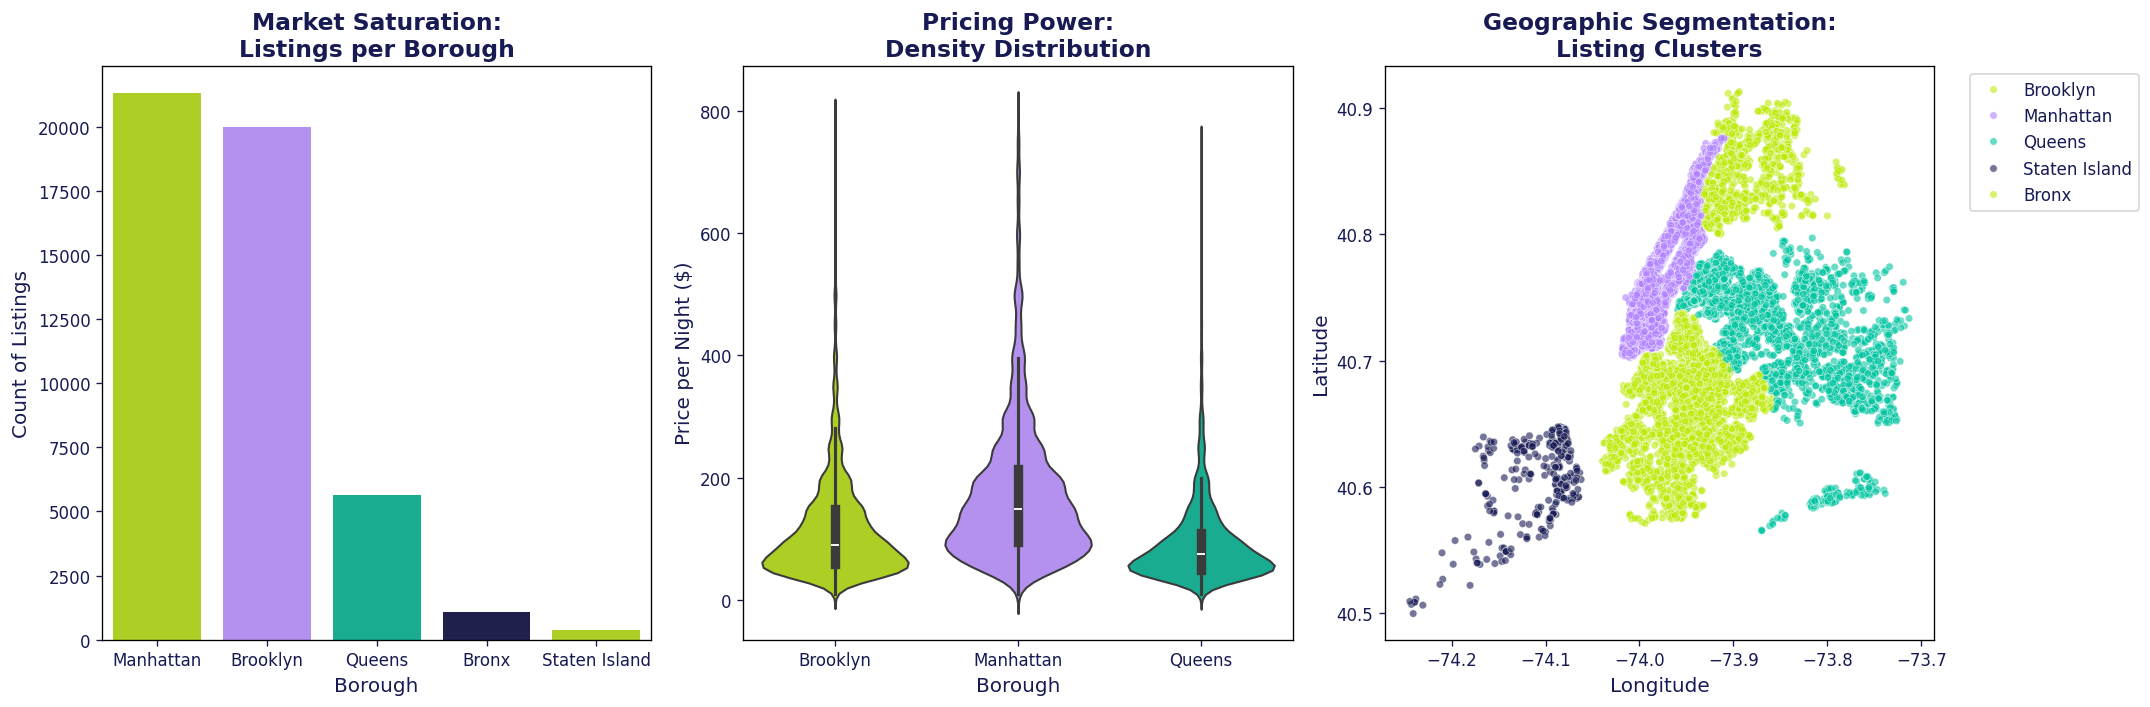

In [10]:
# --- VISUALIZATIONS ---

plt.figure(figsize=(18, 6))

# --- PLOT 1: SATURATION (Bar Chart) ---
plt.subplot(1, 3, 1)
sns.countplot(x='neighbourhood_group', data=df_clean,
              order=df_clean['neighbourhood_group'].value_counts().index,
              palette=COLOR_PALETTE)
plt.title('Market Saturation:\nListings per Borough', fontweight='bold')
plt.xlabel('Borough')
plt.ylabel('Count of Listings')

# --- PLOT 2: PRICING DISTRIBUTION (Violin Plot) ---
plt.subplot(1, 3, 2)
# Focus on Top Boroughs for clearer comparison
top_boroughs = ['Manhattan', 'Brooklyn', 'Queens']
df_filtered = df_clean[df_clean['neighbourhood_group'].isin(top_boroughs)]

sns.violinplot(x='neighbourhood_group', y='price', data=df_filtered,
               palette=COLOR_PALETTE)
plt.title('Pricing Power:\nDensity Distribution', fontweight='bold')
plt.xlabel('Borough')
plt.ylabel('Price per Night ($)')

# --- PLOT 3: STRATEGIC MAP (Scatter) ---
plt.subplot(1, 3, 3)
sns.scatterplot(x='longitude', y='latitude', hue='neighbourhood_group',
                data=df_clean, alpha=0.6, s=20, palette=COLOR_PALETTE)
plt.title('Geographic Segmentation:\nListing Clusters', fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Summary & Interpretation

### Key Findings
1.  **Market Saturation:** My analysis confirms that Manhattan and Brooklyn dominate the market, accounting for the vast majority of listings. This indicates a highly saturated market where I believe new entrants must compete on specific niches rather than just availability.
2.  **Pricing Strategy:** I observed that Manhattan holds the highest pricing power with a significantly higher average and wider distribution. Brooklyn offers a middle ground, while Queens represents a budget-friendly alternative with tighter price clustering.
3.  **Governance & Data Quality:** By imputing missing review data with 0 (interpreting "NaN" as "No Reviews"), I successfully retained 100% of the inventory for analysis. If I had dropped these rows, I would have lost approximately 10,000 listings, which would have biased my results toward older, established hosts.

### Reproducibility Note
To replicate my work, ensure `AB_NYC_2019.csv` is in the working directory and install the necessary libraries via `pip install pandas numpy seaborn matplotlib`.